# Kish Basin halite data

<https://hyss.ie/>

In [1]:
import glob
import os
from textwrap import wrap
from zipfile import BadZipFile, ZipFile

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from geocube.api.core import make_geocube
from shapely.geometry import Polygon

from h2ss import data as rd

In [2]:
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["ytick.minor.size"] = 0

In [3]:
# base data download directory
DATA_DIR = os.path.join("data", "kish-basin")

FILE_NAME = "Kish-Basin-dat-files.zip"

URL = f"https://hyss.ie/wp-content/uploads/2023/07/{FILE_NAME}"

DATA_FILE = os.path.join(DATA_DIR, FILE_NAME)

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

In [4]:
rd.download_data(url=URL, data_dir=DATA_DIR, file_name=FILE_NAME)

Data 'Kish-Basin-dat-files.zip' already exists in 'data/kish-basin'.
Data downloaded on: 2023-09-15 16:03:58.362445+00:00
Download URL: https://hyss.ie/wp-content/uploads/2023/07/Kish-Basin-dat-files.zip
SHA256 hash: 73b3c35059540638bb4f2f85a8417a7bdff051c7f9564880fa71e8c54fcb9f35



In [5]:
ZipFile(DATA_FILE).namelist()

['Flyde Halite Base Depth XYZ Meters.dat',
 'Flyde Halite Thickness - Zone Of Interest - XYZ Meters.dat',
 'Flyde Halite Thickness XYZ Meters.dat',
 'Flyde Halite Top Depth XYZ Meters.dat',
 'Flyde Halite Top TWT XYZ Milliseconds.dat',
 'Kish GIS Map Extent - Square.csv',
 'Mythop Halite Base Depth XYZ Meters.dat',
 'Mythop Halite Thickness XYZ Meters.dat',
 'Mythop Halite Top Depth XYZ Meters.dat',
 'Mythop Halite Top TWT XYZ Milliseconds.dat',
 'Presall Halite Base Depth XYZ Meters-corrected.dat',
 'Presall Halite Thickness - Zone Of Interest - XYZ Meters-corrected.dat',
 'Presall Halite Thickness XYZ Meters-corrected.dat',
 'Presall Halite Top Depth XYZ Meters-corrected.dat',
 'Presall Halite Top TWT XYZ Milliseconds.dat',
 'Rossall Halite Base Depth XYZ Meters.dat',
 'Rossall Halite Thickness - Zone Of Interest - XYZ Meters.dat',
 'Rossall Halite Thickness XYZ Meters.dat',
 'Rossall Halite Top Depth XYZ Meters.dat',
 'Rossall Halite Top TWT XYZ Milliseconds.dat']

In [6]:
# extract archive
try:
    z = ZipFile(DATA_FILE)
    z.extractall(DATA_DIR)
except BadZipFile:
    print("There were issues with the file", DATA_FILE)

## Map extent

In [7]:
with open(
    os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"),
    encoding="utf-8",
) as f:
    print(f.read())

Polygon exported from Kingdom on Thu Nov  3 20:00:33 2022
Coordinate System: ED50 / UTM zone 29N   EPSG: 23029
Polygon Name, Index, X, Y
AREA OF INTEREST,1,742000.000000,5937000.000000
AREA OF INTEREST,2,687000.000000,5937000.000000
AREA OF INTEREST,3,687000.000000,5888000.000000
AREA OF INTEREST,4,742000.000000,5888000.000000
AREA OF INTEREST,5,742000.000000,5937000.000000



In [8]:
CRS = 23029

In [9]:
# create extent polygon
extent = pd.read_csv(
    os.path.join(DATA_DIR, "Kish GIS Map Extent - Square.csv"), skiprows=2
)
extent = gpd.GeoSeries(
    Polygon(
        [
            (extent[" X"][0], extent[" Y"][0]),
            (extent[" X"][1], extent[" Y"][1]),
            (extent[" X"][2], extent[" Y"][2]),
            (extent[" X"][3], extent[" Y"][3]),
        ]
    ),
    crs=CRS,
)

In [10]:
extent.bounds

,minx,miny,maxx,maxy
0,687000.0,5888000.0,742000.0,5937000.0


In [11]:
extent.crs

<Projected CRS: EPSG:23029>
Name: ED50 / UTM zone 29N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe - between 12°W and 6°W - Faroe Islands - onshore; Spain - mainland onshore; Ireland offshore.
- bounds: (-12.0, 36.13, -6.0, 62.41)
Coordinate Operation:
- name: UTM zone 29N
- method: Transverse Mercator
Datum: European Datum 1950
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

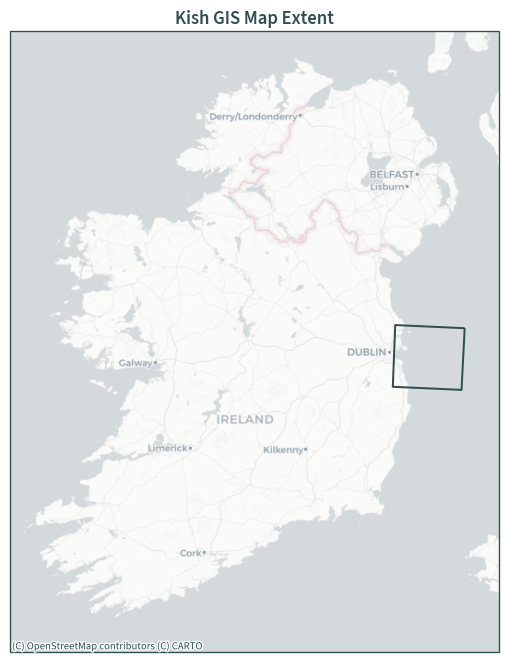

In [13]:
plt.figure(figsize=(7, 7))
ax = plt.axes(projection=ccrs.epsg(3857))
plt.xlim(-1.2e6, -0.55e6)
plt.ylim(6.65e6, 7.475e6)
extent.to_crs(3857).boundary.plot(ax=ax, color="darkslategrey")
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, zoom=7)
plt.title("Kish GIS Map Extent")
plt.tight_layout()
plt.show()

## XYZ data

In [14]:
def read_dat_file(dat_path: str, dat_crs):
    """
    Read XYZ data layers into an Xarray dataset
    """

    gdf = {}
    for dat_file in glob.glob(os.path.join(dat_path, "*.dat")):
        # read each layer as individual dataframes into a dictionary
        gdf[os.path.split(dat_file)[1][:-4]] = pd.read_fwf(
            dat_file, header=None, names=["X", "Y", "Z"]
        )

        # assign layer name to a column
        gdf[os.path.split(dat_file)[1][:-4]]["data"] = os.path.split(dat_file)[
            1
        ][:-4]
    dat_file = glob.glob(os.path.join(dat_path, "*.dat"))[-1]

    # find data resolution
    gdf_xr = (
        gdf[os.path.split(dat_file)[1][:-4]].set_index(["X", "Y"]).to_xarray()
    )
    resx = gdf_xr["X"][1] - gdf_xr["X"][0]
    resy = gdf_xr["Y"][1] - gdf_xr["Y"][0]

    # combine dataframes
    gdf = pd.concat(gdf.values())

    # convert dataframe to geodataframe
    gdf["wkt"] = (
        "POINT (" + gdf["X"].astype(str) + " " + gdf["Y"].astype(str) + ")"
    )
    gdf = gpd.GeoDataFrame(
        gdf, geometry=gpd.GeoSeries.from_wkt(gdf["wkt"]), crs=dat_crs
    )
    gdf.drop(columns=["wkt", "X", "Y"], inplace=True)

    # convert to Xarray dataset
    gdf = make_geocube(
        vector_data=gdf,
        resolution=(-abs(resy), abs(resx)),
        align=(abs(resy / 2), abs(resx / 2)),
        group_by="data",
    )

    return gdf

In [15]:
ds = read_dat_file(DATA_DIR, dat_crs=CRS)

In [16]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:      (data: 19, y: 237, x: 218)
Coordinates:
  * y            (y) float64 2kB 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x            (x) float64 2kB 6.966e+05 6.968e+05 ... 7.398e+05 7.4e+05
  * data         (data) <U66 5kB 'Flyde Halite Base Depth XYZ Meters' ... 'Ro...
    spatial_ref  int64 8B 0
Data variables:
    Z            (data, y, x) float64 8MB nan nan nan nan ... nan nan nan nan

In [17]:
ds.rio.crs

CRS.from_epsg(23029)

In [18]:
ds.rio.resolution()

(200.0, -200.0)

In [19]:
ds.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

In [20]:
xmin, ymin, xmax, ymax = extent.total_bounds

In [21]:
def plot_maps(plot_data):
    """
    Create facet contour plots of the Xarray dataset
    """

    fig = plot_data["Z"].plot.contourf(
        col="data",
        cmap="jet",
        col_wrap=2,
        robust=True,
        levels=15,
        subplot_kws={"projection": ccrs.epsg(CRS)},
        xlim=(xmin, xmax),
        ylim=(ymin, ymax),
        cbar_kwargs={"aspect": 20, "pad": 0.02},
    )

    # add a basemap
    basemap = cx.providers.CartoDB.PositronNoLabels
    for n, axis in enumerate(fig.axs.flat):
        cx.add_basemap(axis, crs=CRS, source=basemap, attribution=False)
        # add attribution for basemap tiles
        if n == 2:
            axis.text(xmin, ymin - 2500, basemap["attribution"], fontsize=8)

    # assign titles this way to prevent truncation/overflow
    for axis, title in zip(fig.axs.flat, plot_data["data"].values):
        axis.set_title("\n".join(wrap(title, 34)), fontsize=10)
    plt.show()

### Halite thickness

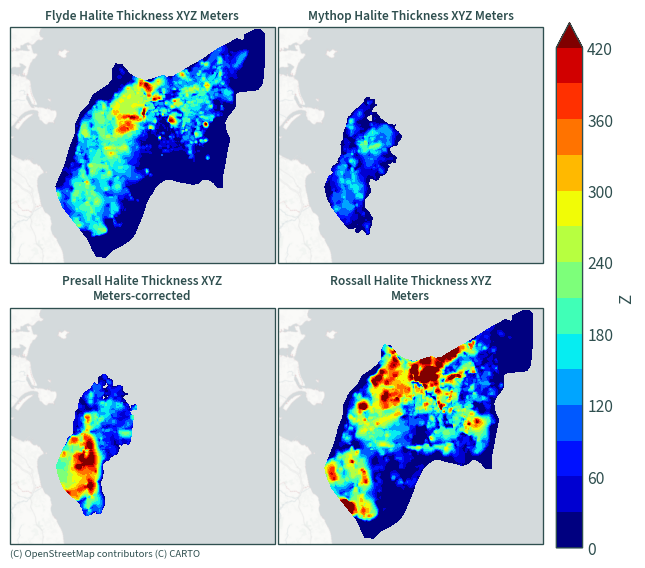

In [22]:
plot_maps(ds.sel(data=[x for x in ds["data"].values if "Thickness XYZ" in x]))

### Halite thickness - zones of interest

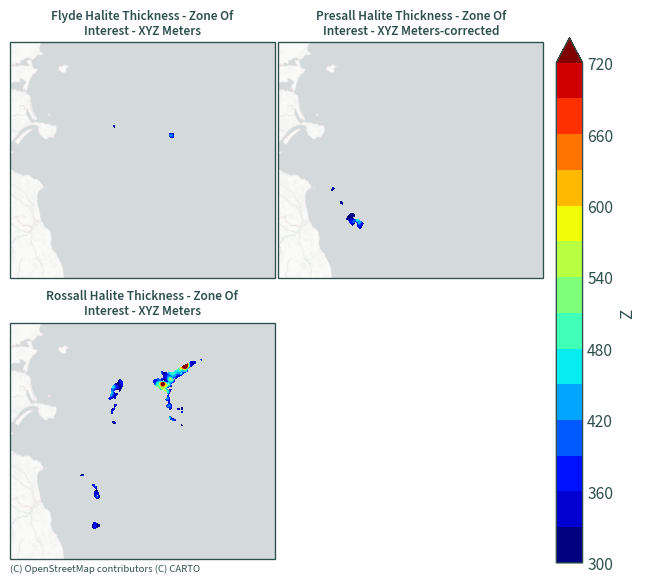

In [23]:
plot_maps(ds.sel(data=[x for x in ds["data"].values if "Zone" in x]))

### Halite base depth

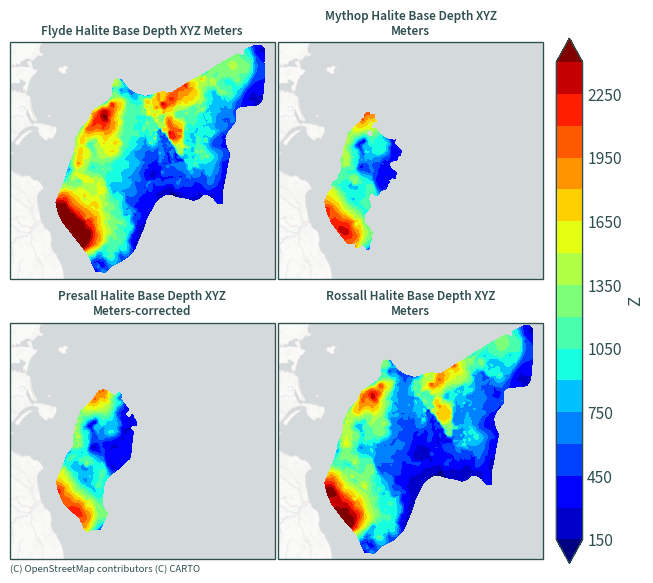

In [24]:
plot_maps(ds.sel(data=[x for x in ds["data"].values if "Base" in x]))

### Halite top depth

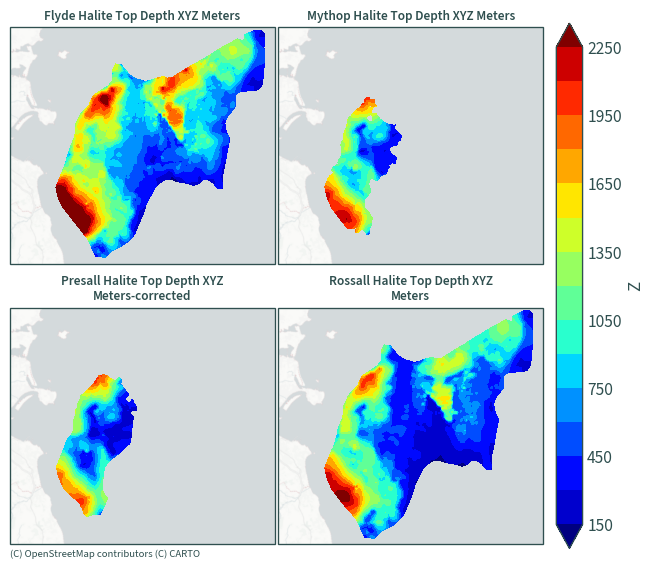

In [25]:
plot_maps(ds.sel(data=[x for x in ds["data"].values if "Top Depth" in x]))

### Halite top TWT (two-way thickness)

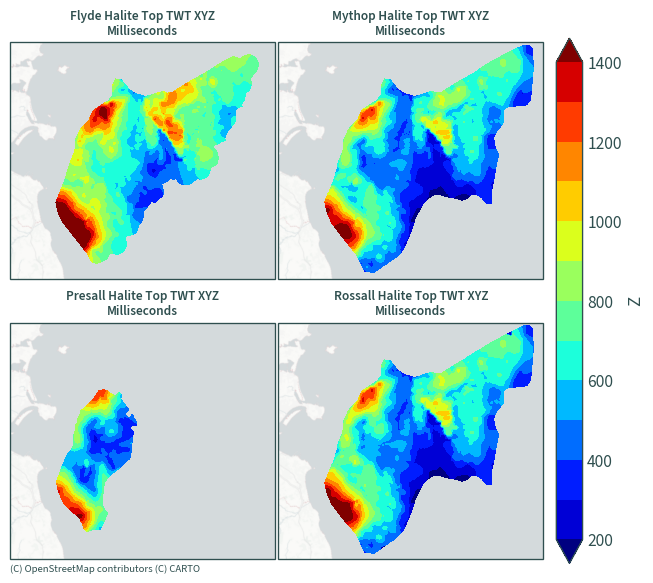

In [26]:
plot_maps(ds.sel(data=[x for x in ds["data"].values if "Millisecond" in x]))